# Deep Learning for Robotics Assignment 2 - Learning Dynamics Model

This assignment will give you a tutorial on learning dynamics models for robot manupulation. Manipulating objects with a robot arm is fundamentally governed by Newtonian Physics. However, obtaining an exact analytical model is impossible due to numerous parameters that cannot be fully observed, making data-driven learning approaches a natural solution. Unlike model-free methods that directly predict robot actions, dynamics models offer the ability to predict the future state of a system based on given actions. This predictive capability presents significant advantages, notably the ease of generalizing an existing dynamics model to various tasks without necessitating retraining.The recent rapid advancements in world modeling, especially OpenAI's Sora, have significantly heightened interest in this research area.

### Imports and Environment Setup

In [1]:
# Derrick Joyce
import os
os.chdir('/content/')

# Make sure you have backuped your model checkpoint under /content/DLM_A2/ckpt/
!rm -rf /content/*

# install the necessary packages
!git clone https://github.com/xsj01/DLM_A2.git

os.chdir('/content/DLM_A2')

Cloning into 'DLM_A2'...
remote: Enumerating objects: 9431, done.
remote: Counting objects: 100% (9431/9431), done.
remote: Compressing objects: 100% (1774/1774), done.
remote: Total 9431 (delta 7663), reused 9419 (delta 7651), pack-reused 0
Receiving objects: 100% (9431/9431), 19.10 MiB | 22.10 MiB/s, done.
Resolving deltas: 100% (7663/7663), done.
Updating files: 100% (9344/9344), done.


In [2]:
%%capture
# Install the necessary packages (it may take a while)
!pip install -r requirements.txt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import hydra
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import gc
import time
import pickle as pkl
from omegaconf import OmegaConf
from datetime import datetime
import glob

from nfd.dataset.dynamics_dataset import DynamicsDataset
from nfd.agents import BaseAgent
from nfd.eval import Evaluator
from nfd.utils.utils import load_config
from helper import train, tsplot, display_gif, seq_pred

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


### Understanding the Enviroment and Datasets

For this assignment you will be working with the pybullet simulator.  This section goes over the enviroments and shows you how training datasets are stored.  Let's take a look at our environments:

<center> <img src="https://raw.githubusercontent.com/xsj01/DLM_A2/main/demo.gif" width="500" align="center">
<center> (In this assignment, you'll be developing methods to achieve this!)

We are working with a robotic arm equipped with a cyan cylinder as a pusher, and our goal is to use the pusher to push the red disk on the table into a designated target area marked by a green circle.  To simplify the problem, we will only consider the dynamics in a two-dimensional space, specifically focusing on the movements on the tabletop surface. To visualize this setup, imagine the x-axis extending directly away from you and the y-axis running to your right in the left image below. Therefore, the scenario within the xy coordinate system can be better understood from a top-down view, as depicted in the right image below. The movement of the end effector is constrained to specific ranges on the tabletop surface: it can only move between 0.25 and 0.75 along the x-axis and between -0.5 and 0.5 along the y-axis .

![title](https://raw.githubusercontent.com/xsj01/DLM_A2/main/topview.png)

We have already generated some training data, and you can visualize them using the scripts blow (blue line is the trajectory of the pusher, and red dots are the trajectory of the pushed object):

In [4]:
# Load the dataset
cfg = load_config('cfg/train.yaml')
train_set = DynamicsDataset(mode='train', seq_length=17, data_dir=cfg.data_dir, cfg = cfg)
val_set = DynamicsDataset(mode='val', seq_length=17, data_dir=cfg.data_dir, cfg = cfg)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


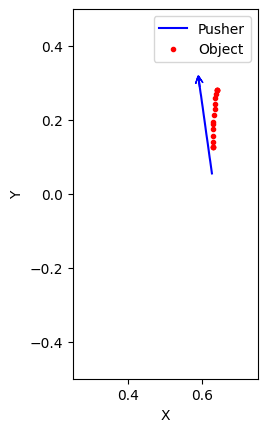

In [5]:
# Visualizing the data
idx = 5 # feel free to change this number
data = val_set[idx]
'''
The trajectory stored in the orignal dataset is in 3D,
the pose is represented by an array of size 7 [qx, qy, qz, qw, x,y,z],
where (qx, qy, qz, qw) is the quaternion representing the rotation
'''
object_traj = data['object_pose'][...,[-3,-2]]
pusher_traj = data['pose'][...,[-3,-2]]

# Visualizing the object and pusher trajectory
plt.plot(pusher_traj[:,0], pusher_traj[:,1],'blue', label='Pusher')
plt.arrow(pusher_traj[-2,0], pusher_traj[-2,1], (pusher_traj[-1,0]-pusher_traj[-2,0])/2, (pusher_traj[-1,1]-pusher_traj[-2,1])/2,head_width=0.02, head_length=0.02, overhang=1.0, color='b' )
plt.plot(object_traj[:,0,0], object_traj[:,0,1],'r.',label='Object')

plt.xlim([0.25, 0.75])
plt.ylim([-0.5, 0.5])
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()


You may observe instances within the dataset where the object remains stationary (for example, at index=2). This occurs because the dataset was generated by moving the pusher randomly on the tabletop, without requiring learned policies or expert demonstrations. Despite being "failure" cases where the robot does not move the object, they could still be valuable for training a dynamics model.

# Implementing the dynamics model

We will implement the dynamics model in this section. The dynamics model is expressed as:

$$s_{t+1} = f(s_t, a_t)$$

where $s_{t+1}$ denotes the object state at time $t + 1$, $s_t$ the state at time $t$, and $a_t$ represents the action at time $t$. For simplicity we assume the system is deterministic and quasi-static, and ignore the orientation. Therefore $s_t$ could simply be the position of the object, e.g. (x,y). The action $a_t$ could be represented by the trajectory of the pusher, denoted as $a_t = [q_t, q_{t+1}]$, where $q_t$ is the position of the pusher at time $t$. We assume the robot is able to precisely move it's end effector to $q_t$ using an Inverse Kinematics solver.

## MLP (10 points)

First let's implement the Dynamics model using an MLP.  This model will predict the subsequent object position given the current object position and the trajectory of the pusher (the action).
The DynamicsMLP takes the current object position as an array of size $B \times 2$ (B is the batch size), and the pusher trajectory as an array of size $B \times 2 \times 2$ (the current and subsequent positions of the pusher in 2D).
However, using a neural network to directly predict these could be hard. Instead, we adjust the neural network input to the state and trajectory with respect to the pusher frame at the current step (only consider translation transformation, and assume pusher orientation is fixed), and the output of the neural network is the difference between the subsequent object position and the current object position, specifically:

$$ \Delta s_{t} = f_{\theta} (s'_t, a'_t) $$
where
$$s'_t = s_t-q_t$$
$$a'_t = q_{t+1} - q_t$$
$$\Delta s_{t} = s_{t+1} - s_t$$

and $f_\theta$ is the neural network. With this approach, the action simplifies to the difference between the subsequent and current pusher positions, so it's reduced to a array of size $B \times 2$.

**Hint**: Make sure you properly **normalize** the input and **denormalize** the output of the neural network, since neural networks work the best when the input and output are of certain distribution. To do this, you can assume the input of the model has standard deviation $\sigma(a'_t)=0.1$, and $\sigma(s'_t)=1$, and you need to normolize them to a standard deviation of 1. As for the output of the model, we assume standard deviation $\sigma(\Delta s_{t})=0.1$. You need to denormalize the output to get the prediction.
You can start with a network with 3 hidden layer, each consisting of 64 units, and make sure there is no activation function after the last layer as the delta motion could be negative.

In [6]:
class DynamicsMLP(nn.Module):
    def __init__(self, state_dim=2, action_dim=2):
        super(DynamicsMLP, self).__init__()

        ######################################
        # Define the model architecture here #
        # Hint: 4 linear layers with an      #
        # activation function between each   #
        # will be plenty powerful.           #
        ######################################

        # raise NotImplementedError
        # 1) Create mlp Sequential list
        input_dim = 4 #state_dim + action_dim
        self.mlp = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,2)
        )


        ######################################
        # End of code                        #
        ######################################

    def forward(self, object_pos, pusher_traj):
        '''
        Args:
        - object_pos (torch.Tensor): object position in 2D, tensor of shape (B x 2)
        - pusher_traj (torch.Tensor): pusher trajectory [[[q0_x, q0_y], [q1_x, q1_y]], ...], tensor of shape (B x 2 x 2)
        Return:
        - output (torch.Tensor): predicted object position, tensor of shape (B x 2)
        '''

        ######################################
        # Define the forward pass here       #
        # Don't forget norm/denormalization  #
        ######################################

        # raise NotImplementedError
        # 1) Define standard deviations
        action_std = 0.1
        state_std = 1.0
        output_std = 0.1


        # 2) Calculate difference of actions at t and t+1
        a_ = pusher_traj[:,1,:] - pusher_traj[:,0,:] # a' = Find difference between action at time t and action at time t+1
        s_ = object_pos - pusher_traj[:,0,:] # Find s' = s at time t - q at time t
        #print("OBJECT TYPE: ", object_pos.type())
        #print("PUSHER TYPE: ", pusher_traj.type())

        # 3) Normalize s' and a' to std of 1
        s_ = s_ / state_std
        a_ = a_ / action_std

        # Concatenate object_pos and pusher_diff along dimension 1
        x = torch.cat((s_, a_), dim=1)

        # Forward pass through the MLP layers
        delta_s = self.mlp(x)

        # 3) Denormalize output
        delta_s = delta_s * output_std

        next_state = delta_s + s_ + pusher_traj[:,0,:] # Need to convert back to world frame
        #print("Output: ", output.shape)

        #print("DELTA S: ", delta_s)

        ######################################
        # End of code                        #
        ######################################

        return next_state

## Sequential Prediction (10 points)

Then let's implement the dynamics model to predict multiple steps.  The DynamicsPrediction takes the current state of the object and the trajectory of the pusher as input.  It predicts the position of the object after the pusher follows the given trajectory. The module makes this prediction by using your DynamicsMLP for each step in the prediction horizon.

In [7]:
class DynamicsPrediction(nn.Module):
    def __init__(self, args=None):
        super(DynamicsPrediction, self).__init__()
        # args.use_gpu = args['gpu']
        self.args = {'gpu':[0]}
        if args: self.args.update(args)

        self.device  = torch.device('cuda' if self.args['gpu'] else 'cpu')
        #self.device = 'cpu'
        #print(self.device)

        self.mlp = DynamicsMLP()
        self.mlp.to(self.device)

        self.state_dim = 2
        self.n_particle = 1 # there is only one object in the scene

    def set_model(self, model_path):
        '''
        load trained model
        '''
        if model_path:
            print('Set model from:', model_path)
            model=torch.load(model_path, map_location=self.device)
            if type(model) is DynamicsPrediction or hasattr(model, 'mlp'):
                self.mlp = model.mlp
            elif hasattr(model, 'model'):
                self.mlp=model.model
            else:
                self.mlp = model
            self.mlp.to(self.device)
            self.mlp.eval()
            # print(type(self.mlp))

    def forward(self, state: torch.Tensor, pusher_traj:torch.Tensor):
        '''
        Args:
        - state: current state of the object of shape (B, 1, 2) or (1, 2),
                 here 1 indicates that there is only one single object in the scene.
        - pusher_traj: trajectory of the pusher of shape (B, T, 2)

        Return:
        - state_pred: predicted position of the object of shape (B, 1, 2)
        '''

        horizon = pusher_traj.shape[1]-1
        B = pusher_traj.shape[0] # batch size

        # repeat the state in case we want to predict for multiple actions from the same state
        if len(state.shape)==2:
            state = state.repeat(B, 1, 1)



        ###############################################
        # Define the forward pass here                #
        # 1. Initialize current state                 #
        # 2. Loop over prediction horizon.            #
        # 3. Use DynamicsMLP to predict next          #
        #    state based on current state             #
        #    and action at time t, then update        #
        #    current state to the predicted state     #
        # 4. Return final state prediction            #
        #                                             #
        # Hint: Action input of MLP at time t is      #
        #       pusher traj at time t and t+1         #
        ###############################################

        # raise NotImplementedError

        # 1) Initialize current state (s' = s at t - q at t)
        current_state = state.squeeze(1)
        #print("STATES: ", current_state)
        #print("Current State Shape: ", current_state.shape)


        # 2) Loop over prediction horizon
        for i in range(horizon):
          # 3) Predict next state based on current state and action at time t, update current state to the predicted state
          action = pusher_traj[:, i:i+2, :].reshape(B, 2,2)  # Concatenate pusher traj at time t and t+1 for shape (Bx2x2)
          #print("PUSHER TRAJ DEVICE: ", action.device)
          #print("STATE DEVICE: ", current_state.device)
          #print("PUSHER_TRAJ: ", action)
          current_state = self.mlp(current_state, action) #Just pass in raw states and actions, calculate s' and a' inside the mlp
          #print("CURRENT_STATE: ", current_state)


        # Final State prediction
        state_pred = current_state.unsqueeze(1)  # Unsqueeze to make output shape (Bx1x2)
        #print("STATE PRED: ", state_pred)
        #print("PUSHER TRAJ: ", pusher_traj)
        #print("STATE PRED: ", state_pred)
        #torch.set_printoptions(profile="default")


        ######################################
        # End of code                        #
        ######################################
        #print("State Pred Shape: ", state_pred.shape)
        return state_pred

## Training (10 points)

Now it is time to train the model, we will evaluate the performance of the model based on the accuracy of single step prediction (error_single) and the accuracy of sequential prediction (error_multi). You should be able to achieve the Target Sequential Prediction Accuracy within 50 epochs (around 3 minutes).  We will only be grading the sequential prediction accuracy.

**Target Sequential Prediction Accuracy**: Error (Multi) less than 1e-2

In [8]:
cfg = load_config('cfg/train.yaml')

# cfg.lr = 1e-2
# cfg.batch_size = 256
cfg.n_epoch = 100

model_name = 'mlp'
model = DynamicsPrediction(cfg)

# We are using L1 loss to train the dynamics model.
# If you are interested in how the model is trained, take a look at the `train()` in helper.py
training_results = train(model, cfg, name=model_name)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0 Training Loss: 3.281E-03, Error (Single): 2.679E-03, Error (Multi): 4.091E-02
Epoch 1 Training Loss: 2.659E-03, Error (Single): 2.494E-03, Error (Multi): 3.930E-02
Epoch 2 Training Loss: 2.624E-03, Error (Single): 2.548E-03, Error (Multi): 3.983E-02
Epoch 3 Training Loss: 2.657E-03, Error (Single): 2.591E-03, Error (Multi): 4.022E-02
Epoch 4 Training Loss: 2.646E-03, Error (Single): 2.513E-03, Error (Multi): 3.941E-02
Epoch 5 Training Loss: 2.669E-03, Error (Single): 2.484E-03, Error (Multi): 3.855E-02
Epoch 6 Training Loss: 2.587E-03, Error (Single): 2.457E-03, Error (Multi): 3.794E-02
Epoch 7 Training Loss: 2.483E-03, Error (Single): 2.437E-03, Error (Multi): 3.507E-02
Epoch 8 Training Loss: 2.217E-03, Error (Single): 2.056E-03, Error (Multi): 3.057E-02
Epoch 9 Training Loss: 1.858E-03, Error (Single): 1.627E-03, Error (Multi): 2.800E-02
Epoch 10 Training Loss: 1.466E-03, Error (Single): 1.336E-03, Error (Multi): 2.908E-02
Epoch 11 Training Loss: 1.353E-03, Error (Single): 1.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 99 Training Loss: 3.507E-04, Error (Single): 3.297E-04, Error (Multi): 4.949E-03


You can visualize the prediction result for a specific case

Set model from: ./ckpt/mlp/model_best.pt


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/content/DLM_A2/helper.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action).float().unsqueeze(0).to(model.device)


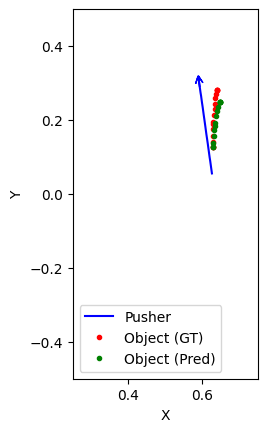

In [9]:
# load the best model ckpt
model_path = f'./ckpt/{model_name}/model_best.pt'
model.set_model(model_path)

idx = 5 # feel free to change this number

data = val_set[idx]

object_traj = data['object_pose'][...,[-3,-2]]
pusher_traj = data['pose'][...,[-3,-2]]

object_traj_pred = seq_pred(model, object_traj[0], pusher_traj)

plt.plot(pusher_traj[:,0], pusher_traj[:,1],'blue', label='Pusher')
plt.arrow(pusher_traj[-2,0], pusher_traj[-2,1], (pusher_traj[-1,0]-pusher_traj[-2,0])/2, (pusher_traj[-1,1]-pusher_traj[-2,1])/2,head_width=0.02, head_length=0.02, overhang=1.0, color='b' )
plt.plot(object_traj[:,0,0], object_traj[:,0,1],'r.',label='Object (GT)')
plt.plot(object_traj_pred[:,0,0], object_traj_pred[:,0,1],'g.',label='Object (Pred)')
plt.xlim([0.25, 0.75])
plt.ylim([-0.5, 0.5])
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

Then let's plot the learning curve, make sure to include this plot in your submission.

Error (Multi-step): 4.442E-03


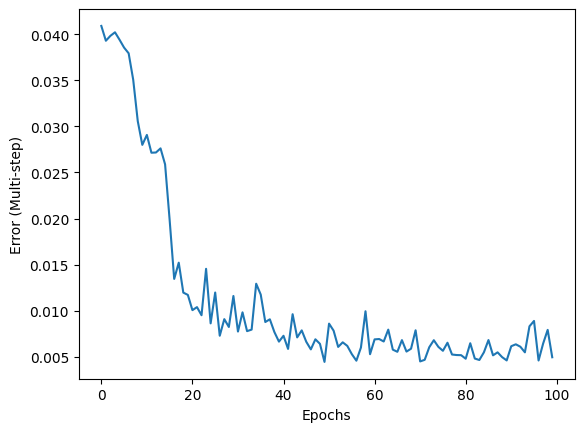

In [10]:
plt.plot(training_results['error_multi'])
plt.xlabel('Epochs')
plt.ylabel('Error (Multi-step)')
err = min(training_results['error_multi'])
print(f'Error (Multi-step): {err:.3E}' )

# Using Learned dynamics model for planning

In [17]:
# Initialize the evaluation scene
cfg = load_config('cfg/eval.yaml')
scene = Evaluator(cfg)

## Objective function (10 points)

Now let's use the learned dynamics model for planning, firstly we will be implementing the objective function for the planning. The objective function J is a signed distance function (sdf) of the object position and the boundary of the target region.  Since the target region is a circle, the sdf is simply:

$$
J(s, g) = ||s-g||-r
$$
where $s$ is the position of the object, $g$ is the position of the center of the target region, and $r$ is the radius of the target region

Note: make sure your implementation can handle batch input, and only contains pytorch functions, it is very important for the following step as we need to use pytorch's autograd functionality for gradient-based optimization.

In [11]:
def planning_objective(states, goal_pos, goal_size):
    '''
    Args:
    - states (torch.Tensor): current state of the object of shape (B, 1, 2),
            here 1 indicates that there is only one single object in the scene.
    - goal_pos (torch.Tensor): position of the goal of shape (2,)
    - goal_size (float): diameter of the target region
    Returns:
    - output (torch.Tensor): objective function value of shape (B,)
    '''
    states.requires_grad_(True)
    goal_pos.requires_grad_(True)
    original_shape = states.shape
    states = states.view(-1, original_shape[-2], original_shape[-1])

    ########################################
    # Define the planning objective here   #
    #                                      #
    # Hint: Output is J(states, goal_pos) #
    #       as defined above              #
    ########################################

    # raise NotImplementedError

    # 1) Shrink states to shape (B x 2)
    #states = states.squeeze(1)
    #print("STATES: ", states)
    goal_pos = goal_pos.view(1,1,2)

    # 2) Compute the magnitude of the vector and subtract the radius of the goal circle
    output = torch.linalg.norm(states-goal_pos,dim=-1) - goal_size/2

    # print("Planning Objective Shape", output.shape)
    #print("Planning Objective: ", output)

    ######################################
    # End of code                        #
    ######################################

    return output.view(original_shape[:-2])

## Random Shooting (20 points)

Then let's implement the random shooting algorithm for planning.  For this algorithm, we randomly sample N pusher trajectories and choose the one that minimizes our objective funciton.  We assume the pusher moves in straight line, so we only need to know the positions of two endpoints to determine a trajectory. More specifically, the random shooting algorithm is run as follows:

* Randomly sample 2N points as the endpoints of N line segments
* Interpolate each endpoints pair and obtain the trajectory as a sequence of pusher positions
* Use the dynamics model to predict the state of the object after the pusher move follows the trajectory
* Compute the objective function for predicted object states
* Find the trajectory that results in the minimum objective as the output




Firstly, we will be implementing the function to sample line segments endpoints.
You will implement the `sample_endpoints` function to randomly sample N pairs of endpoints within the boundary of the tabletop.
The function takes 4 variables as input, the number of endpoints pair, the boundary of the tabletop (represented as $2\times 2$ matrix: [[min_x, max_x], [min_y, max_y]]), the margin of the bounds (the minimum distance between the pusher and bounds), and an optional distance range as a list of the minimum and maximum distance between the two endpoints. The function returns an pytorch tensor of size $N \times 2 \times 2$, the last dimension represents the x,y coordinates of the point.

In [12]:
########################################################
# (Optional) Feel free to include helper functions     #
########################################################



########################################################
#              End of your helper functions            #
########################################################

def sample_endpoints(N, bounds, margin=0.05 ,distance_range=[0.2,0.8]):
    '''
    Sample N endpoints pair within the bounds
    Args:
    - N: number of sampled endpoints pairs
    - bounds: range of the sampled points [[min_x, max_x], [min_y, max_y]]
    - (optional) margin: shrink the bounds by the margin value (diameter of the object), as we don't want to push the object out of table boundary
    - (optional) distance_range: the minimum and maximum distance between the two endpoints

    Returns:
    - endpoints: tensor of shape (N, 2, 2): [[[x1_start, y1_start], [x1_end, y1_end]], [[x2_start, y2_start], [x2_end, y2_end]], ...]
    '''
    ###############################################
    # Your codes here                             #
    #                                             #
    # Hint: Taking into account the optional      #
    #       arguments while sampling points will  #
    #       increase your performance             #
    ###############################################

    # raise NotImplementedError
    x_min = bounds[0][0]
    x_max = bounds[0][1]
    y_min = bounds[1][0]
    y_max = bounds[1][1]

    #print(f"Bounds: {x_min}, {x_max}, {y_min}, {y_max}")

    # 1) Loop through N
    endpoints = []
    for i in range(N):
      # 2) Sample an x and y start point within the margin and bounds
      start_x = torch.FloatTensor(1).uniform_(x_min + margin, x_max - margin)
      start_y = torch.FloatTensor(1).uniform_(y_min + margin, y_max - margin)

      # 3) Sample an x and y endpoint withing the distance_range and bounds
      dist_min = distance_range[0]
      dist_max = distance_range[1]

      # Ensure the end point is within the distance bounds
      rand_dist_x = torch.FloatTensor(1).uniform_(dist_min, dist_max)
      rand_dist_y = torch.FloatTensor(1).uniform_(dist_min, dist_max)

      # Sample angle
      rand_angle = torch.FloatTensor(1).uniform_(0, 2*torch.pi)

      # Calculate end point
      end_x = start_x + rand_dist_x * torch.cos(rand_angle)
      end_y = start_y + rand_dist_y * torch.sin(rand_angle)

      # Ensure all points are within the table bounds
      start_x = torch.clamp(start_x,x_min+margin,x_max-margin)
      start_y = torch.clamp(start_y,y_min+margin,y_max-margin)
      end_x = torch.clamp(end_x,x_min+margin,x_max-margin)
      end_y = torch.clamp(end_y,y_min+margin,y_max-margin)


      # Concatenate start and endpoints and append to the growing list
      endpoint_pair = [[start_x,start_y],[end_x,end_y]]
      #print("ENDPOINT PAIR: ", endpoint_pair)
      endpoints.append(endpoint_pair)

      # if(start_x < x_min or start_x > x_max):
      #   print(f"Invalid start_x Endpoint: {start_x}")
      # if(start_y < y_min or start_y > y_max):
      #   print(f"Invalid start_y Endpoint: {start_y}")
      # if(end_x < x_min or end_x > x_max):
      #   print(f"Invalid end_x Endpoint: {end_x}")
      # if(end_y < y_min or end_y > y_max):
      #   print(f"Invalid end_y Endpoint: {end_y}")

    endpoints = torch.tensor(endpoints)
    #print("ENDPOINTS SHAPE: ", endpoints.shape)


    ######################################
    # End of code                        #
    ######################################
    return endpoints

Then let's implement the function `endpoints2trajectory` to interpolate between pairs of endpoint positions and generate the trajectory

Note: make sure your implementation could handle batch input, and only contains pytorch functions.

In [13]:

def endpoints2trajectory(endpoints, horizon):
    '''
    Interpolate trajectory from endpoints

    Args:
    - endpoints (torch.Tensor): A batch of endpoints pairs of shape (B, 2, 2)
        e.g. :
        [
            [[q0_x, q0_y], [q1_x, q1_y]],
            ...
        ]
    - horizon (int): number of steps to plan (horizon=T-1), T is the length of the returned trajectory

    Return:
    - output (torch.Tensor) of shape (B, T, 2), where T=horizon+1
        e.g. :
        [
            [[x0, y0], [x1, y1], ..., [x_horizon, y_horizon]]
            ...
        ]
    '''

    ######################################
    # Your code here                     #
    #                                    #
    # Hint: Use torch.linspace           #
    ######################################

    # raise NotImplementedError

    # Extract start and end points
    start_points = endpoints[:, 0]  # Shape: (B, 2)
    end_points = endpoints[:, 1]    # Shape: (B, 2)
    print("Endpoints SHAPE: ", endpoints.shape)
    print("START POINTS SHAPE: ", start_points.shape)
    print("END POINTS SHAPE: ", end_points.shape)

    # Create interpolation parameter
    w = torch.linspace(0, 1, steps=horizon + 1, device=endpoints.device).unsqueeze(1)  # Shape: (T, 1)
    print("W SHAPE: ", w.shape)

    # Expand dimensions for broadcasting
    start_points_expanded = start_points.unsqueeze(1)  # Shape: (B, 1, 2)
    end_points_expanded = end_points.unsqueeze(1)      # Shape: (B, 1, 2)

    # Perform interpolation
    output = w * start_points_expanded + (1 - w) * end_points_expanded  # Broadcasting happens here

    return output


    #print("TRAJ: ", output)
    #print("TRAJ SHAPE: ", output.shape)
    #print("TRAJ DEVICE: ", output.device)
    #print("ENDPOINTS DEVICE: ", endpoints.device)

    ######################################
    # End of code                        #
    ######################################


    return output

Finally, let's implement the random shooting algorithm for planning, you will be implementing the `trajectory_generation` function that includes the following steps:

1. Randomly sample N pairs of endpoints using `sample_endpoints`
2. Interpolate each endpoints pair and obtain the trajectory as a sequence of pusher positions using `endpoints2trajectory`
3. Use the dynamics model `self.pred` to predict the state of the object after the pusher move follows the trajectory
4. Compute the objective function for predicted object states
5. Find the trajectory that results in the **minimum** objective value as the output

In [18]:
class ShootAgent(BaseAgent):
    def __init__(self, cfg):
        super().__init__(cfg)

        self.horizon = cfg.horizon
        self.loss_plan = planning_objective
        self.distance_threshold = 0.047

        dpi_cfg = OmegaConf.load('cfg/train.yaml')
        dpi_cfg.update(cfg)
        dpi_cfg.env = 'PilePush'
        self.cfg = dpi_cfg
        self.pred = DynamicsPrediction(self.cfg)

        self.name = 'Shoot'+str(self.n_sample)


    def trajectory_generation(self, object_pose, goal_pos, goal_size):
        '''
        Args:
        - object_pos (torch.Tensor): position of the object of shape (1, 2), 1 indicates there is only one object in the scene
        - goal_pos (torch.Tensor): position of the target region of shape (2,)
        - goal_size (float): diameter of the target region

        Returns:
        - trajectory (np.ndarray): trajectory of the pusher of shape (T, 2), where T = self.horizon+1
        '''

        # sample self.n_sample pairs of endpoints using sample_endpoints
        endpoints = sample_endpoints(self.n_sample, self.bounds[:2,:])
        endpoints = torch.tensor(endpoints, device=self.device, dtype=self.dtype)

        # Exclude initial endpoints that intersect with the object to prevent simulation errors.
        dist = (object_pose[None,:,:] - endpoints[:,[0],:]).norm(dim=-1)
        cost = (dist-self.distance_threshold).clamp(max=0.).sum(axis=-1)
        valid_idx = torch.where(cost>=0.)
        endpoints = endpoints[valid_idx[0], ...]

        # use endpoints2trajectory to get trajectorys from sampled endpoints
        sampled_trajs = endpoints2trajectory(endpoints, horizon=self.horizon).contiguous()
        sampled_trajs = torch.tensor(sampled_trajs, device = torch.device('cuda'), dtype=self.dtype)
        #sampled_trajs.to(self.dtype)

        ######################################
        # Your implementation here           #
        ######################################

        # raise NotImplementedError

        #print("Sample_Trajs: ", sampled_trajs)
        min_objective = torch.tensor(float('inf'))
        min_traj = None

        #print("OBJECT POSE DEVICE", object_pose.device)
        #print("SAMPLED_TRAJ DEVICE", sampled_trajs.device)
        # 1) Pass in sampled_trajs straight to self.pred
        state_preds = self.pred(object_pose,sampled_trajs)

        #print("State_Pred Shape", state_pred.shape)
        #print("State_Pred", state_pred)

        # 2) Calculate the Objectives
        objectives = planning_objective(state_preds, goal_pos, goal_size)
        #print("TRAJECTORY: ", traj)
        #print("TRAJ OBJECTIVE: ", objective)

        # 3) Find the min objective / trajectory
        min_objective = torch.min(objectives)
        min_index = torch.argmin(objectives)
        min_traj = sampled_trajs[min_index]

        print("MIN OBJECTIVE: ", min_objective)

        trajectory = min_traj
        trajectory = trajectory.cpu()
        #print("TRAJECTORY DEVICE: ", trajectory.device)
        ######################################
        # End of code                        #
        ######################################

        return trajectory

Let's run some rollout experiments to evaluate performance,
We will undertake these experiments across
N=20 distinct test scenarios. In each scenario, the initial position of the object and the target position will be randomly sampled. Given that the robot might not successfully move the object into the target region with a single push, we will execute the trajectory generation process up to 5 times (5 pushes) for each scenario. During each push, given the current object position, the `trajectory_generation` function will generate a planned trajectory, which the robot's end effector will then follow in an open-loop manner. Once the movement completes, we will record the current position of the object and reintroduce it into the `trajectory_generation` for the next push.


In [ ]:
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_sample=256
agent = ShootAgent(cfg)
agent.name = agent.name +'_' +model_name # The results will be saved to ./results/{agent.name}/*.gif

model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path) # load the dynamics model



scene.cfg.save_dir
# The full evaluation process takes approximately 20 minutes. For initial testing, you can start with N=1.
# But make sure that the results for your submission are based on runs with at least N=10 (and use the same N for all the following experiments)
result_shoot = scene.eval(agent, N=20)

Let's now plot the reward curve. In this context, a reward of 1.0 means that the object has been successfully pushed into the target region. If the object overlaps with the target's boundary, a fractional reward between 0 and 1.0 is assigned. In all other cases, the reward is 0.

**Target Average Reward:** 0.6 (after 5 pushes).

Average Reward (5 step): 0.7775443524122239


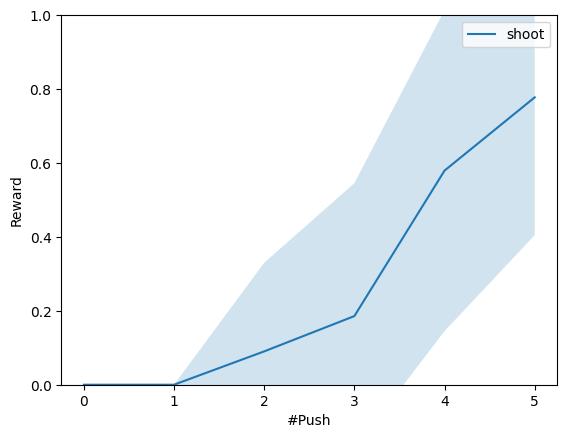

In [ ]:
tsplot(result_shoot['reward'], label='shoot')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (5 step): {result_shoot['reward'][:,5].mean()}")

You can also visualize one specific testing scenario

In [ ]:
idx = 9 # feel free to change this number (idx < N)
filepath = sorted(glob.glob(f'./results/{agent.name}/*.gif'))[idx]
display_gif(filepath)

## Trajectory Optimization (20 points)

We will improve the random shooting algorithm by using gradient-based optimization. Note that in some literature this method is also known as the random shooting algorithm, but we will refer to it as gradient-based trajectory optimization here to differentiate it from non-gradient-based method we just implemented above.

Our goal is to find a trajectory that minimize the objective function through gradient decent. As a straight line trajectory could be defined by its endpoints, we are directly optimizing and taking gradient steps on the endpoints of the trajectories.  (We are **not** updating our dynamics model, objective function, or re-sampling any trajectories during the optimization) The gradient-based trajectory optimization algorithm proceeds as follows:
1. Randomly generate `n_sample` endpoint pairs with `sample_endpoints`, convert these into trajectories, predict object states using the dynamics model, and calculate the objective values (similar to step 1-5 of random shooting method).
2. Select the endpoint pairs with the top k smallest objective values. The optimization variables are the positions of k endpoint pairs, initialized with the selected top k endpoints.
-----
**Repeat 3-8 for n_iter=30 cycles**
3. Covert endpoints into k trajectories using `endpoints2trajectory`.
4. Use the dynamics model to predict the object's states after the pusher follows the trajectory.
5. Compute the objective value based on the predicted state.
6. Calculate the gradient of the objective value with respect to the endpoints by backpropagating the objective function to the endpoint positions.
7. Update the endpoint positions using an optimizer, such as Adam.
8. If the updated endpoint position exceeds the boundaries, adjust it back within the designated bounds.
---
9. Return trajectory with lowest objective value

Note: for step 3-5 make sure your implementation should handle batch input, and only contains pytorch functions.

In [15]:
class OptAgent(ShootAgent):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.n_opt = cfg.n_opt
        self.name = 'Opt'+str(self.n_opt)+'s%d'%cfg.n_sample
        self.n_iter = cfg.n_iter
        self.gamma = cfg.gamma
        self.optimizer = None # feel free to change this line for the Experiments with different optimizer

    def trajectory_generation(self, object_pose, goal_pos, goal_size):
        '''
        Args:
        - object_pos (torch.Tensor): position of the object of shape (1, 2), 1 indicates there is only one object in the scene
        - goal_pos (torch.Tensor): position of the target region of shape (2,)
        - goal_size (float): diameter of the target region

        Returns:
        - trajectory (np.ndarray): trajectory of the pusher of shape (T, 2), where T = self.horizon+1
        '''

        # Sample self.n_sample pairs of endpoints using sample_endpoints
        endpoints = sample_endpoints(self.n_sample, self.bounds[:2,:])
        endpoints = torch.tensor(endpoints, device=self.device, dtype=self.dtype)

        # Exclude initial endpoints that intersect with the object to prevent simulation errors.
        dist = (object_pose[None,:,:] - endpoints[:,[0],:]).norm(dim=-1)
        cost = (dist-self.distance_threshold).clamp(max=0.).sum(axis=-1)
        valid_idx = torch.where(cost>=0.)
        endpoints = endpoints[valid_idx[0], ...]

        # use endpoints2trajectory to get trajectorys from sampled endpoints
        sampled_trajs = endpoints2trajectory(endpoints, horizon=self.horizon).contiguous()
        sampled_trajs = torch.tensor(sampled_trajs, device = torch.device('cuda'), dtype=self.dtype)

        k = self.n_opt # number of trajectory to be optimized

        ###########################################################################
        # Compute k_best_endpoints using original random shooting algorithm.      #
        # Steps 1 and 2                                                           #
        ###########################################################################

        k_best_endpoints = []

        # 1) Pass in sampled_trajs straight to self.pred
        state_pred = self.pred(object_pose,sampled_trajs)
        #print("State_Pred Shape", state_pred.shape)
        #print("State_Pred", state_pred)

        # 2) Calculate the Objectives
        objectives = planning_objective(state_pred, goal_pos, goal_size)
        #print("TRAJECTORY: ", traj)
        #print("TRAJ OBJECTIVE: ", objective)

        # 3) Find the k min objectives / trajectories
        min_objectives, min_indices = torch.topk(objectives, k, largest=False)
        min_trajs = sampled_trajs[min_indices]

        k_best_endpoints = endpoints[min_indices][:,[0,-1],:].contiguous()

        print("K BEST MIN OBJECTIVES: ", min_objectives)

        # # 4) Find the k_best_endpoints from the min_trajs
        # for traj in min_trajs:
        #   start_pair = traj[0].tolist()
        #   end_pair = traj[-1].tolist()
        #   pair = [start_pair,end_pair]
        #   k_best_endpoints.append(pair)

        # k_best_endpoints = torch.tensor(k_best_endpoints, device = torch.device('cuda'), dtype=self.dtype)
        print("K BEST ENDPOINTS: ", k_best_endpoints)
        print("K BEST ENDPOINTS SHAPE: ", k_best_endpoints.shape)
        # raise NotImplementedError


        ######################################
        # End of code                        #
        ######################################

        # set k_best_endpoints as the variable for optimization
        k_best_endpoints = k_best_endpoints.clone().detach().requires_grad_(True)
        #k_best_endpoints = nn.Parameter(k_best_endpoints,requires_grad=True)
        optimizer = torch.optim.Adam([k_best_endpoints], lr=self.gamma) # feel free to change this line for the Experiments with different optimizer

        for i in range(self.n_iter):
            ########################################
            # Optimize Endpoints                   #
            # Steps 3-7                            #
            ########################################
            optimizer.zero_grad()
            # raise NotImplementedError
            # 1) Convert k_best_endpoints to trajectories
            k_best_trajs = endpoints2trajectory(k_best_endpoints, horizon=self.horizon).contiguous()
            #k_best_trajs = k_best_trajs.to(torch.device('cuda'))
            #k_best_trajs = k_best_trajs.requires_grad_(True)


            # 2) Use Dynamics model to predict future states
            state_preds = self.pred(object_pose,k_best_trajs)
            # state_preds.requires_grad_(True)
            #print("STATE PREDS: ", state_preds)

            # 3) Compute Objective Values
            # goal_pos.requires_grad_(True)
            objectives = planning_objective(state_preds, goal_pos, goal_size)
            # objectives.requires_grad_(True)
            print(f"{self.n_iter} OBJECTIVES: ", objectives)

            # 4) Calculate the gradient of the objective value wrt to the endpoints by
            # backpropagating the objective function to the endpoint positions

            sum_obj = torch.sum(objectives)
            sum_obj.backward()
            #print("IS LEAF", sum_obj.is_leaf)

            # Attempt Gradient Clipping
            # k_best_endpoints.grad.data = torch.max(k_best_endpoints.grad.data, torch.full_like(k_best_endpoints.grad.data, 1e-3))


            print("K_BEST_ENDPOINTS_GRAD: ", k_best_endpoints.grad)
            # 5) Update the endpoint positions using an optimizer
            optimizer.step()



            ######################################
            # End of code                        #
            ######################################

            # We have handled step 8 for you
            with torch.no_grad():
                self.clamp(k_best_endpoints)

        ########################################
        # Select best trajectory               #
        # Step 9                               #
        ########################################

        # raise NotImplementedError
        min_objective = torch.min(objectives)
        min_index = torch.argmin(objectives)
        min_traj = k_best_trajs[min_index]

        print("MIN OBJECTIVE: ", min_objective)

        trajectory = min_traj
        trajectory = trajectory.detach()
        trajectory = trajectory.cpu()


        ######################################
        # End of code                        #
        ######################################


        return trajectory

Then let's run the run the rollout experiments

In [ ]:
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_sample = 256
cfg.n_opt = 4
agent = OptAgent(cfg)
agent.name = agent.name +'_' +model_name # The results will be saved to ./results/{agent.name}/*.gif

model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path) # load the dynamics model

result_opt = scene.eval(agent, N=20) # Run the experiments

You can visualize the performance by plotting the reward curves for both the  the gradient-based optimization method and random shooting method. The gradient-based trajectory optimization method should outperform the random shooting method.
Your trajectory optimization method should be able to achieve the target average reward within 3 pushes.

**Target Average Reward:**  0.7 (within **3** pushes)

Average Reward (3 step): 0.9221290558576584


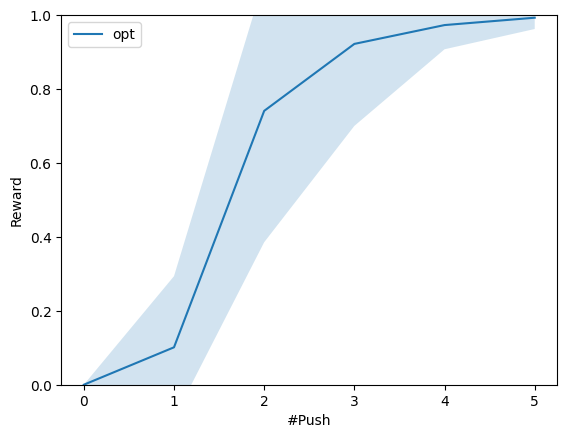

In [ ]:
# tsplot(result_shoot['reward'], label='shoot')
tsplot(result_opt['reward'], label='opt')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (3 step): {result_opt['reward'][:,3].mean()}")

Visualizing one testing scenario


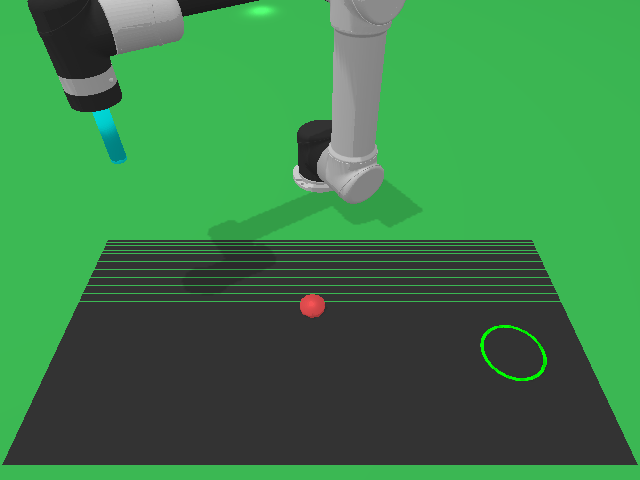

In [ ]:
idx = 9 # feel free to change this number (idx < N)

filepath = sorted(glob.glob(f'./results/{agent.name}/*.gif'))[idx]
display_gif(filepath)

# Experiments (20 points)

Now it is time to do some experiments with the models you implemented.  For each section you need to come up with a hypothesis, run an experiment to test that hypothesis, and then analyze whether or not your hypothesis was proved or disproved.  These do not need to be novel discoveries, we just want you to see how rollout performance are impacted by different aspects of the models.  For each section below the points breakdown is as follows:

* (2pt) **Hypothesis** - Test how one aspect of the models you implemented effect the rollout performance
* (4pt) **Experiment** -  Describe the experiment you ran and visualize the result with **at least one figure**.
* (4pt) **Analysis** - Explain whether or not your hypothesis was proved or disproved.  What would be an interesting next experiment after seeing these results?


To evaluate the performance of the rollout experiments, consider selecting a metric that highlights the differences effectively, such as the average reward achieved after 3 pushes.

**To get full credit**, you need to run an experiment from each setting across at least **5** different parameter values to justify your hypothesis.

## **Sampling parameters (10 points):**
We have provided some examples
1. Different `n_sample` for random shooting method
2. Different `n_sample` for gradient-based trajectory optimization method
3. Different `n_opt` for gradient-based trajectory optimization method

Example Hypothesis: If I increase `n_opt` (while fixing `n_sample`), I will see increased performance for rollout.

### TODO:
**You can add however many code blocks here, but leave the most essential ones upon submission to prove your work.**

**Enter your hypotheses here:** If I decrease n_sample for random shooting method, I will see a lower performance for rollout. If I increase n_sample for random shooting method, I will see a higher performance for rollout. Will test n_sample = (64, 128, 256 - baseline, 512, 1024)

**Enter your experiment here** (Include figures, brief explanation of the figures. You may use more than one cell):



**Experiment 1: N_Sample = 64**

In [ ]:
# Experiment 1: Changing n_sample to 64
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_sample = 64 # change this numer for n_sample (default value is 256)
cfg.n_opt = 4 # change this numer for n_opt (default value is 4)
# agent = OptAgent(cfg)
agent = ShootAgent(cfg) # Doing experiments with ShootAgent until OptAgent is fixed
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N_Sample = 64 Average Reward (within 5 pushes)**

Average Reward (5 step): 0.1


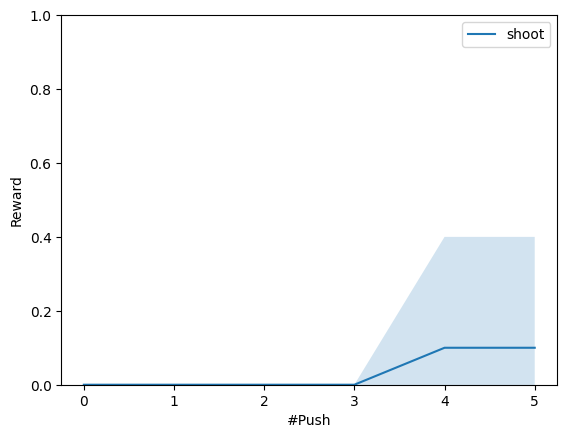

In [ ]:
tsplot(result_exp['reward'], label='shoot')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (5 step): {result_exp['reward'][:,5].mean()}")
n_sample_64_reward = result_exp['reward'][:,5].mean()

**Experiment 2: N_Sample = 128**

In [ ]:
# Experiment 2: Changing n_sample to 128
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_sample = 128 # change this numer for n_sample (default value is 256)
cfg.n_opt = 4 # change this numer for n_opt (default value is 4)
# agent = OptAgent(cfg)
agent = ShootAgent(cfg) # Doing experiments with ShootAgent until OptAgent is fixed
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N_Sample = 128 Average Reward (within 5 pushes)**

Average Reward (5 step): 0.46590048670768736


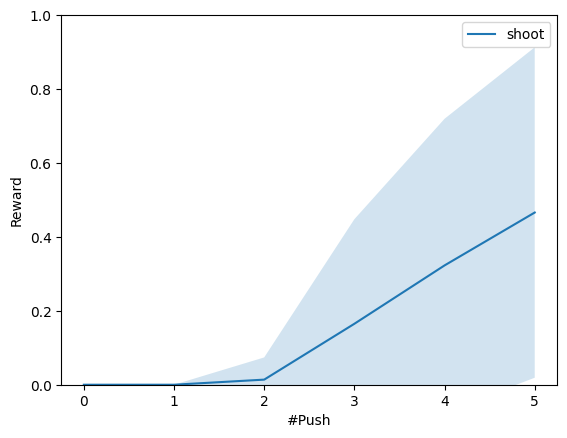

In [ ]:
tsplot(result_exp['reward'], label='shoot')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (5 step): {result_exp['reward'][:,5].mean()}")
n_sample_128_reward = result_exp['reward'][:,5].mean()

**Experiment 3: N_Sample = 256 (Baseline)**

In [ ]:
# Experiment 3: Changing n_sample to 256
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_sample = 256 # change this numer for n_sample (default value is 256)
cfg.n_opt = 4 # change this numer for n_opt (default value is 4)
# agent = OptAgent(cfg)
agent = ShootAgent(cfg) # Doing experiments with ShootAgent until OptAgent is fixed
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N_Sample = 256 Average Reward (within 5 pushes)**

Average Reward (5 step): 0.5082697391510009


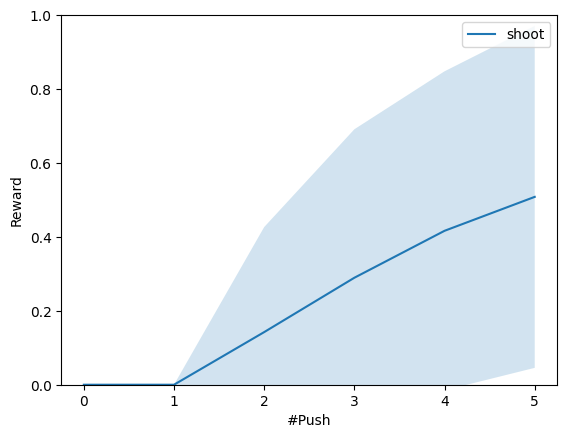

In [ ]:
tsplot(result_exp['reward'], label='shoot')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (5 step): {result_exp['reward'][:,5].mean()}")
n_sample_256_reward = result_exp['reward'][:,5].mean()

**Experiment 4: N_Sample = 512**

In [ ]:
# Experiment 4: Changing n_sample to 512
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_sample = 512 # change this numer for n_sample (default value is 256)
cfg.n_opt = 4 # change this numer for n_opt (default value is 4)
# agent = OptAgent(cfg)
agent = ShootAgent(cfg) # Doing experiments with ShootAgent until OptAgent is fixed
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N_Sample = 512 Average Reward (within 5 pushes)**

Average Reward (5 step): 0.9110533118247985


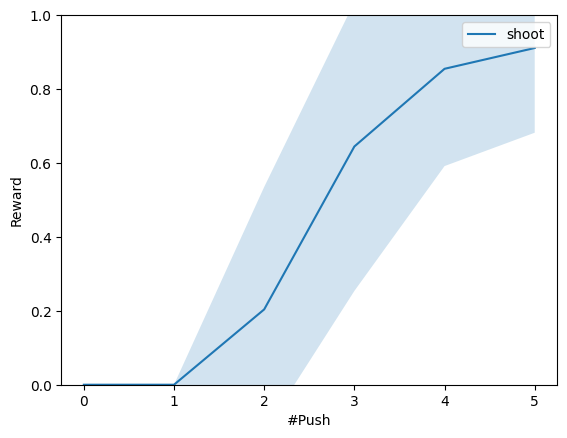

In [ ]:
tsplot(result_exp['reward'], label='shoot')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (5 step): {result_exp['reward'][:,5].mean()}")
n_sample_512_reward = result_exp['reward'][:,5].mean()

**Experiment 5: N_Sample = 1024**

In [ ]:
# Experiment 5: Changing n_sample to 1024
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_sample = 1024 # change this numer for n_sample (default value is 256)
cfg.n_opt = 4 # change this numer for n_opt (default value is 4)
# agent = OptAgent(cfg)
agent = ShootAgent(cfg) # Doing experiments with ShootAgent until OptAgent is fixed
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N_Sample = 1024 Average Reward (within 5 pushes)**

Average Reward (5 step): 0.8750783383846283


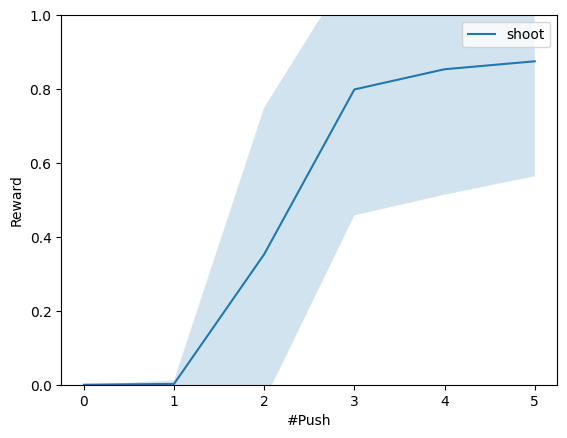

In [ ]:
tsplot(result_exp['reward'], label='shoot')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (5 step): {result_exp['reward'][:,5].mean()}")
n_sample_1024_reward = result_exp['reward'][:,5].mean()

**Enter your analysis here** (be concrete about how each result validates or invalidates your hypothesis and why):

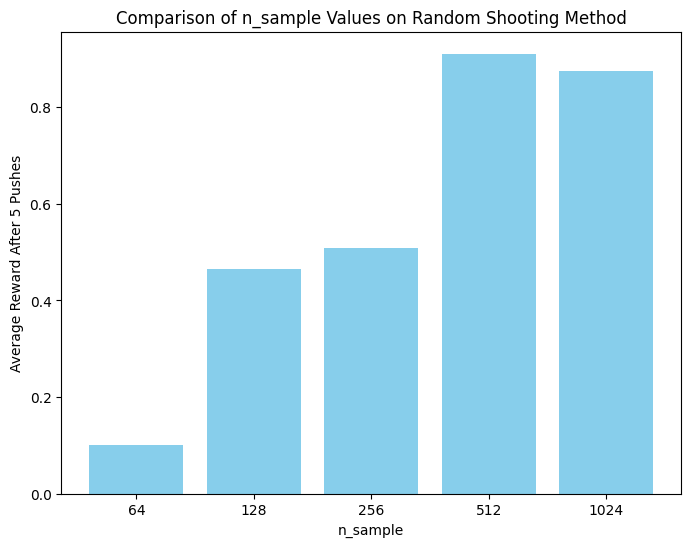

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['64', '128', '256', '512', '1024']
# values = [n_sample_64_reward, n_sample_128_reward, n_sample_256_reward, n_sample_512_reward, n_sample_1024_reward]
values = [0.1, 0.46590048670768736 , 0.5082697391510009, 0.9110533118247985, 0.8750783383846283]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('n_sample')
plt.ylabel('Average Reward After 5 Pushes')
plt.title('Comparison of n_sample Values on Random Shooting Method')
plt.show()

**ANALYSIS:** My hypothesis was that the average reward for random shooting method would increase if n_sample increased and decrease if n_sample decreased. As shown by the bar chart above, this hypothesis was proven correct except for n_sample = 1024 which had a slightly lower performance than the n_sample = 512. An interesting next experiment would be to test a wider range of n_samples to determine if 1024 is a resistance or if there could be continued increased performance with even higher n_samples.

## **Optimization setting for gradient-based optimization (10 points):**
We have provided some examples
1. Different iteration steps `n_iter`
2. Different learning rate `gamma`
3. Different optimizer e.g. SGD, AdaGrad (you only need to try 3 different optimization methods for this)

Example Hypothesis:
If I increase iteration steps `n_iter`, I will see improved performance for rollout

### TODO:
**You can add however many code blocks here, but leave the most essential ones upon submission to prove your work.**

**Enter your hypotheses here:** If I decrease n_iter for gradient-based optimization method, I will see a lower performance for rollout. If I increase n_iter for gradient_based optimization method, I will see a higher performance for rollout. Will test n_iter = (10, 20, 30 - baseline, 40, 50)

**Enter your experiment here** (Include figures, brief explanation of the figures. You may use more than one cell):



**Experiment 1: N-Iter = 10**

In [ ]:
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_iter = 10  #change the number of iteration (default value is 30)
#cfg.gamma = 1e-2 #change the learning rate of the optimizer (default is 1e-2)
agent = OptAgent(cfg)
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N-Iter = 10 Average Reward (within 3 pushes)**

Average Reward (3 step): 0.9645376414060592


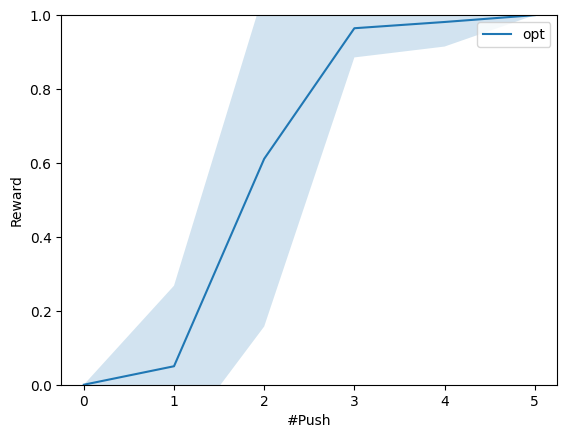

In [ ]:
tsplot(result_exp['reward'], label='opt')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (3 step): {result_exp['reward'][:,3].mean()}")
n_iter_10_reward = result_exp['reward'][:,3].mean()

**Experiment 2: N-Iter = 20**

In [ ]:
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_iter = 20  #change the number of iteration (default value is 30)
#cfg.gamma = 1e-2 #change the learning rate of the optimizer (default is 1e-2)
agent = OptAgent(cfg)
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N-Iter = 20 Average Reward (within 3 pushes)**

Average Reward (3 step): 0.7868638873100281


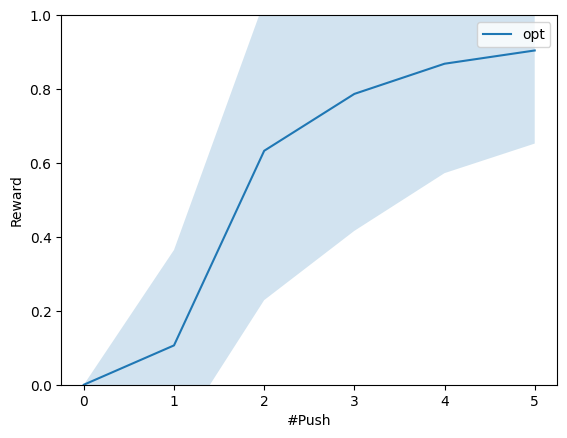

In [ ]:
tsplot(result_exp['reward'], label='opt')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (3 step): {result_exp['reward'][:,3].mean()}")
n_iter_20_reward = result_exp['reward'][:,3].mean()

**Experiment 3: N-Iter = 30 (Baseline)**

In [ ]:
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_iter = 30  #change the number of iteration (default value is 30)
#cfg.gamma = 1e-2 #change the learning rate of the optimizer (default is 1e-2)
agent = OptAgent(cfg)
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N-Iter = 30 Average Reward (within 3 pushes)**

Average Reward (3 step): 0.9221290558576584


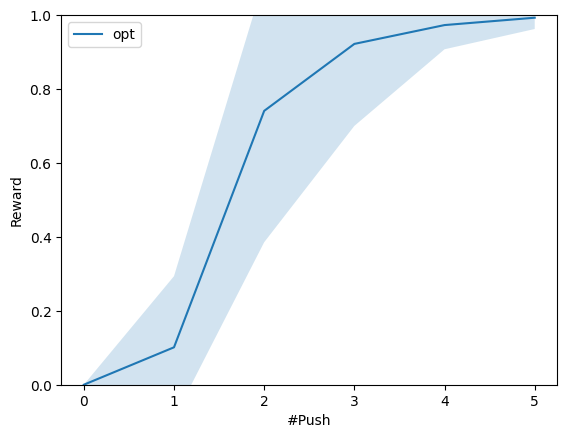

In [ ]:
tsplot(result_exp['reward'], label='opt')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (3 step): {result_exp['reward'][:,3].mean()}")
n_iter_30_reward = result_exp['reward'][:,3].mean()

**Experiment 4: N-Iter = 40**

In [ ]:
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_iter = 40  #change the number of iteration (default value is 30)
#cfg.gamma = 1e-2 #change the learning rate of the optimizer (default is 1e-2)
agent = OptAgent(cfg)
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N-Iter = 40 Average Reward (within 3 pushes)**

Average Reward (3 step): 0.9378448784351349


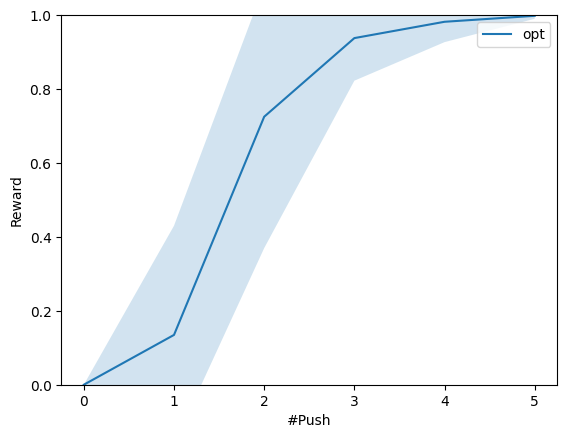

In [ ]:
tsplot(result_exp['reward'], label='opt')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (3 step): {result_exp['reward'][:,3].mean()}")
n_iter_40_reward = result_exp['reward'][:,3].mean()

**Experiment 5: N-Iter = 50**

In [ ]:
model_name = 'mlp'
cfg = load_config('cfg/eval.yaml')
cfg.n_iter = 50  #change the number of iteration (default value is 30)
#cfg.gamma = 1e-2 #change the learning rate of the optimizer (default is 1e-2)
agent = OptAgent(cfg)
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

**N-Iter = 50 Average Reward (within 3 pushes)**

Average Reward (3 step): 0.9825474470853806


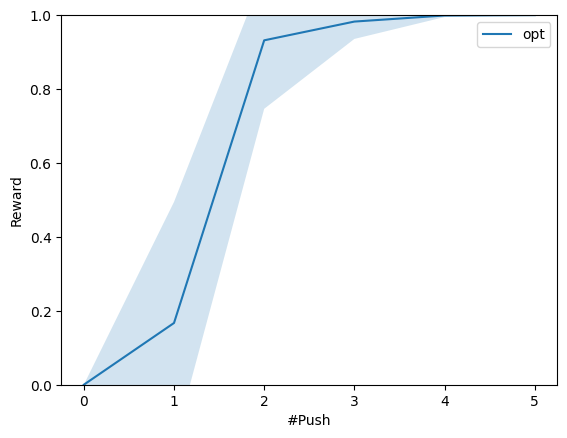

In [20]:
tsplot(result_exp['reward'], label='opt')
plt.legend()
plt.ylim([0,1])
plt.xlabel('#Push')
plt.ylabel('Reward')
print(f"Average Reward (3 step): {result_exp['reward'][:,3].mean()}")
n_iter_50_reward = result_exp['reward'][:,3].mean()

**Enter your analysis here** (be concrete about how each result validates or invalidates your hypothesis and why):

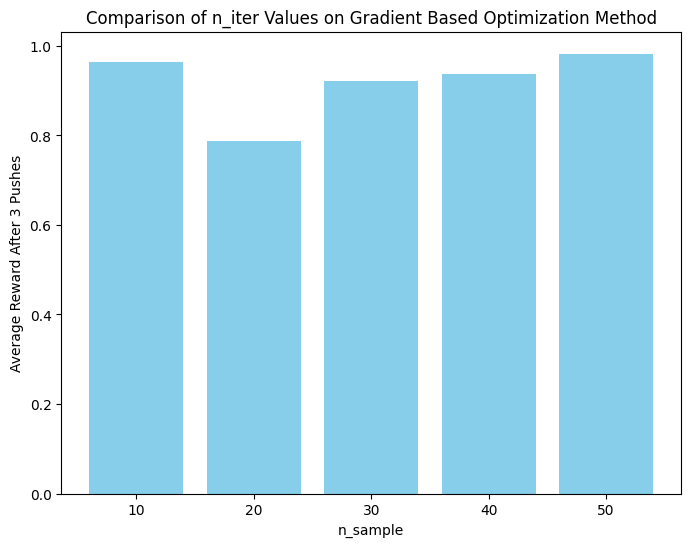

In [21]:
import matplotlib.pyplot as plt

# Data
labels = ['10', '20', '30', '40', '50']
# values = [n_iter_10_reward, n_iter_20_reward, n_iter_30_reward, n_iter_40_reward, n_iter_50_reward]
values = [0.9645376414060592, 0.7868638873100281 , 0.9221290558576584, 0.9378448784351349, 0.9825474470853806]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('n_sample')
plt.ylabel('Average Reward After 3 Pushes')
plt.title('Comparison of n_iter Values on Gradient Based Optimization Method')
plt.show()

**ANALYSIS:** My hypothesis was that the average reward for gradient optimization would increase if the n_iter increased and decrease if the n_iter decreased. This hypothesis was proven true except for n_iter = 10 which had a surprisingly high reward. An interesting next experiment would be to vary n_sample for gradient optimization to see which has a higher influence on the reward and determine if they are correlated or uncorrelated.

**Congratulations on reaching the end of this assignments!** We have prepared some bonus questions for you to explore further.

## **[Bonus] Prediction Performance and Rollout Performance** (10 points)

Example Hypothesis:
A dynamics model with better prediction performance is generally expected to have better rollout performance.


You can train models with varying parameters such as epochs, learning rates, etc., to obtain models with differing levels of prediction accuracy (as measured by error_multi metric). Then, utilize these models for trajectory optimization.

In [ ]:
# train the model
cfg.n_epoch = 50
model_name = 'mlp_ep50'
model = DynamicsPrediction(cfg)
train(model, cfg, name=model_name)

# run rollout experiments
cfg = load_config('cfg/eval.yaml')
agent = OptAgent(cfg) # Use trajectory optimization for this experiment
agent.name = agent.name +'_' +model_name
model_path = f'./ckpt/{model_name}/model_best.pt'
agent.set_model(model_path)
result_exp = scene.eval(agent, N=20)

## TODO - Submit to Gradescope
This is the end of the assignment

**Please download this notebook as a PDF and submit to gradescope**

Make sure you have not deleted any cell outputs that have final answers/success rates

## Further Readings
In this assignments, we have focused on scenarios involving only one object in the scene. If you're interested in how to train a dynamics model capable of handling numerous particles (a topic referred to as 'piles manipulation'), you might find the following papers helpful:
* [The Surprising Effectiveness of Linear Models for Visual Foresight in Object
Pile Manipulation](https://link.springer.com/chapter/10.1007/978-3-030-66723-8_21)
* [Learning Particle Dynamics for Manipulating Rigid Bodies, Deformable Objects, and Fluids](http://dpi.csail.mit.edu/)
* [Neural Field Dynamics Model for Granular Object Piles Manipulation](https://arxiv.org/abs/2311.00802)

------

Written By Shangjie Xue